In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import correlate
from scipy.linalg import toeplitz
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import correlate
from scipy.signal import windows
from scipy.signal import find_peaks, peak_widths

# Moving average filter for smoothing the signal
def moving_average(data, window_size):
    if window_size % 2 == 0:
        window_size += 1
    half_window = window_size // 2
    padded_data = np.pad(data, (half_window, half_window))
    window = np.ones(window_size) / window_size
    filtered_data = np.convolve(padded_data, window, mode='same')
    
    return filtered_data

# Function to detect peaks in the signal and calculate their widths
def detect_peaks_with_width(signal, height_threshold=0.5, min_distance=100):
    baseline = np.median(signal)
    signal_range = np.max(signal) - baseline
    threshold = baseline + height_threshold * signal_range
    peaks, properties = find_peaks(signal, height=threshold, distance=min_distance)

    results_half = peak_widths(signal, peaks, rel_height=0.5)

    intervals = []
    for i in range(len(peaks)):
        start = int(results_half[2][i])  
        end = int(results_half[3][i])
        if end-start<50:
            continue
        else:
            intervals.append((start, end))
    return intervals

# Function to find intervals where the mask is True for more than a specified duration
def find_intervals(mask, flag):
    if flag == 0:
        min = 60
    else:
        min = 100
    intervals = []
    start = None
    for i, value in enumerate(mask):
        if value and start is None:
            start = i
        elif not value and start is not None:
            if (i - 1) - start > min:
                intervals.append((start, i - 1))
            start = None
            
    if start is not None:
        if (len(mask) - 1) - start > min:
            intervals.append((start, len(mask) - 1))
    
    return intervals

# Function to find subpixel shift between adjacent rows in the image using cross-correlation
def find_shift_subpixel(image):
    dis = [0]
    means = np.mean(image, axis=1, keepdims=True)
    stds = np.std(image, axis=1, keepdims=True)
    image = (image - means) / (stds+1e-6)
   
    for row in range(image.shape[0] - 1):
        correlation = correlate(image[row], image[row+1], mode='full')
        max_index = np.argmax(correlation)
        shift = max_index - (len(image[row]) - 1)
        
        if 1 <= max_index <= len(correlation) - 2: 
            R_m1 = correlation[max_index - 1]
            R_0 = correlation[max_index]      
            R_p1 = correlation[max_index + 1]

            subpixel_offset = 0.5 * (R_m1 - R_p1) / (R_m1 - 2 * R_0 + R_p1)
            shift += subpixel_offset 
        
        dis.append(shift)
    
    return np.array(dis)

# Adaptive AR interpolation for filling missing data in the signal
def adaptive_ar_interpolation(signal, single_point_segment_index, ar_order=None, max_iterations=3):
    dis = np.zeros_like(signal)
    
    signal = signal[single_point_segment_index[0][0]:single_point_segment_index[1][1]]
    missing_indices = np.where(signal == 0)[0]
    signal_filled = np.array(signal, dtype=np.float64)

    if ar_order is None:
        ar_order = 3 * len(missing_indices) + 2

    signal_filled[missing_indices] = 0.0

    for iteration in range(max_iterations):
        known_indices = np.where(~np.isnan(signal_filled))[0]
        known_signal = signal_filled[known_indices]
        if len(known_signal) <= ar_order:
            raise ValueError("Not enough known samples to estimate AR parameters.")

        ar_model = AutoReg(known_signal, lags=ar_order, old_names=False)
        ar_fit = ar_model.fit()
        ar_params = ar_fit.params[1:]


        toeplitz_col = np.zeros(ar_order)
        toeplitz_col[:len(ar_params)] = ar_params
        B_matrix = toeplitz(toeplitz_col)

        for idx in missing_indices:
            start_idx = max(0, idx - ar_order)
            end_idx = idx
            context_indices = np.arange(start_idx, end_idx)

            context_values = signal_filled[context_indices]
            if len(context_values) < ar_order:
                context_values = np.pad(context_values, (ar_order - len(context_values), 0), mode='constant')

            interpolated_value = np.dot(ar_params[:len(context_values)], context_values[::-1])
            signal_filled[idx] = interpolated_value
    
    dis[single_point_segment_index[0][0]:single_point_segment_index[1][1]] = signal_filled
    return dis

# Function to apply a low-pass Butterworth filter to the signal
def lowpass_filter(data, cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to plot the FFT of the signal and annotate the dominant frequency
def plot_fft(dis, freq_range=(20, 2000), fs=1 / (11.4e-6)):
    """
    Plot the signal's FFT results.
    """
    
    N = len(dis)
    X = np.fft.fft(dis, N * 8)  # Zero-padded FFT for better frequency resolution
    f = np.fft.fftfreq(len(X), d=1.0 / fs)  

    f_pos = f[:len(f) // 2]
    X_pos = X[:len(f) // 2]
    A = np.abs(X_pos) 


    min_freq, max_freq = freq_range
    index_range = np.where((f_pos >= min_freq) & (f_pos <= max_freq))[0]  
    f_filtered = f_pos[index_range]
    A_filtered = A[index_range]


    max_amp = np.max(A_filtered)
    measured_freq = f_filtered[np.argmax(A_filtered)]
    
    plt.plot(f_pos, A, color="red")
    plt.xlim(freq_range)
    plt.xlabel("Frequency (Hz)", fontsize='medium')
    plt.ylabel("Amplitude", fontsize='medium')
    plt.title("FFT Amplitude Spectrum", fontsize='medium')
    plt.annotate(f"{measured_freq:.2f} Hz",
                 xy=(measured_freq, max_amp-1),
                 xytext=(measured_freq + 40, max_amp-5),
                 arrowprops=dict(facecolor='red', shrink=0.01),
                 fontsize='medium', color='red')
    plt.tight_layout() 
    plt.show()

    return measured_freq

In [2]:
folder_path = '../sample_data/'
files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.jpg')])
final_result = []
T = 11.4e-6
fs = int(1/T)
start_index = 0
end_index = 10
dis_all_speckle = [[] for _ in range(20)]
for id in range(start_index, end_index):
    file_path = folder_path + files[id]
    img_data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    img_data_copy = img_data.copy()
    col_intensity = np.average(img_data_copy, axis=0)
    filtered_col = gaussian_filter1d(col_intensity, sigma=10)
    peaks_col = detect_peaks_with_width(filtered_col, height_threshold=0.2, min_distance=100)
    
    # plt.plot(filtered_col, label="Filtered Column Intensity", color="blue")
    # plt.xlabel('Col Index',fontsize=14)
    # plt.ylabel('Col-wise Average Energy',fontsize=14)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # for start, end in peaks_col:
    #     plt.axvspan(start, end, alpha=0.3)
    # plt.show()

    row_intensity = np.average(img_data_copy, axis=1)
    filtered_row = gaussian_filter1d(row_intensity,sigma=2)
    
    global_mean = np.mean(filtered_row)
    global_std = np.std(filtered_row)
    local_adjustment = np.percentile(filtered_row, 90) - np.percentile(filtered_row, 10)
    threshold = global_mean - 0.5 * global_std - 0.1 * local_adjustment

    above_threshold = filtered_row > threshold
    peaks_row = find_intervals(above_threshold, 1)
    if len(peaks_row) >= 3:
        peaks_row = sorted(peaks_row, key=lambda x: (-(x[1] - x[0]), x[0]))[:2]
        peaks_row = sorted(peaks_row, key=lambda x: x[0])

    # plt.plot(filtered_row, label="Filtered Column Intensity", color="blue")
    # plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    # plt.xlabel('Row Index',fontsize=14)
    # plt.ylabel('Row-wise Average Energy',fontsize=14)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # for start, end in peaks_row:
    #     plt.axvspan(start, end, alpha=0.3)
    # plt.show()
    
    height, width = img_data.shape
    num_speckle = len(peaks_col)
    for i in range(num_speckle): # Process each detected speckle region and compute the displacement signal
        vis_frame = np.zeros((height+int((1/30 - height*T)/T)-1, peaks_col[i][1]-peaks_col[i][0]))
        dis = np.zeros(height)
        for j in range(2):
            i_speckle_img = img_data[peaks_row[j][0]:peaks_row[j][1], peaks_col[i][0]:peaks_col[i][1]]
            vis_frame[peaks_row[j][0]:peaks_row[j][1],:] = i_speckle_img
            i_speckle_img  = cv2.medianBlur(i_speckle_img , 5)
            dis_tmp = find_shift_subpixel(i_speckle_img)
            dis_tmp = lowpass_filter(dis_tmp, 2000, fs, order=3)
            dis[peaks_row[j][0]:peaks_row[j][1]] = dis_tmp
        dis = adaptive_ar_interpolation(dis, peaks_row, ar_order=3, max_iterations=1)
        dis = np.concatenate((dis, np.zeros(int((1/30 - height*T)/T)-1)))            
        M = len(dis)
        window_length = peaks_row[1][1] - peaks_row[0][0]
        hann_window = windows.hamming(window_length)
        padded_window = np.zeros(M)
        start_index = peaks_row[0][0]
        padded_window[start_index:start_index + window_length] = hann_window
        dis = dis*padded_window
        dis_all_speckle[i].extend(dis)

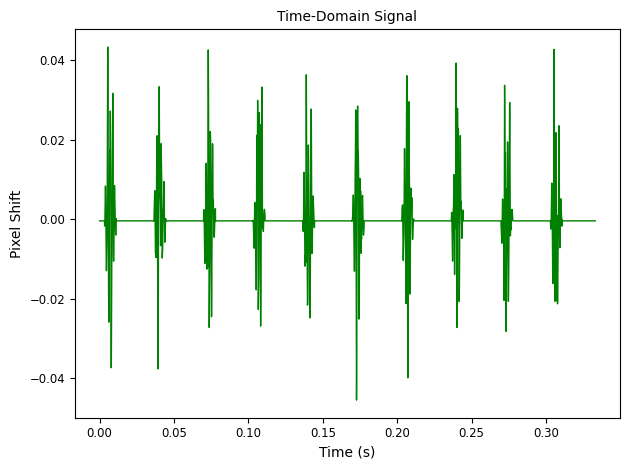

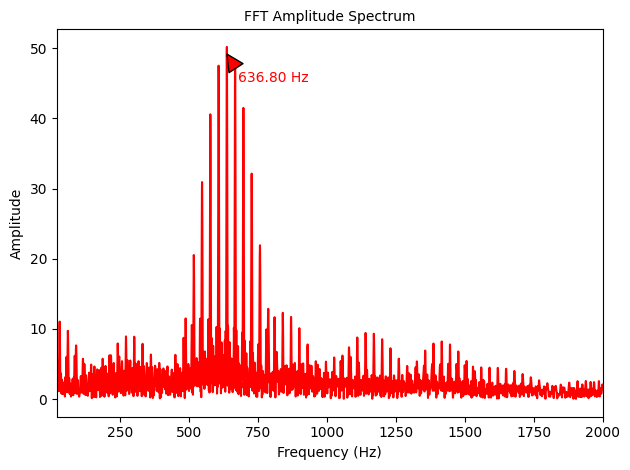

np.float64(636.8033153661876)

In [3]:
# Plot the time-domain signal for the first speckle and its FFT
shift = dis_all_speckle[0]
n = len(shift)
t = np.arange(n) * T
signal = (shift - np.mean(shift))
plt.plot(t, signal, color='green', linewidth=1.0)
plt.xlabel('Time (s)', fontsize='medium')
plt.ylabel('Pixel Shift', fontsize='medium')
plt.tick_params(axis='x', labelsize='small')
plt.tick_params(axis='y', labelsize='small')
plt.title('Time-Domain Signal', fontsize='medium')
plt.tight_layout()
plt.show()
plot_fft(shift,fs=fs)